## PIP do Pennylane

In [1]:
%pip install pennylane

Note: you may need to restart the kernel to use updated packages.


## Código - Pré-processamento e clustering clássico

In [4]:
from sklearn.metrics.cluster import silhouette_score
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import cluster
from sklearn import preprocessing
from sklearn.metrics import rand_score, davies_bouldin_score
import pennylane as qml
from pennylane import numpy as np_qml
from pennylane.optimize import NesterovMomentumOptimizer,RotosolveOptimizer,GradientDescentOptimizer
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def normalize_data_transformY(X,y,range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(0, np.pi))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  y = 2*y -1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y, edgecolor="k")
    plt.show()
  return X_scaled, y

In [6]:
def cluster_classical(X,y, cluster_metric, unsupervised=True):
  # make a list of algorithms to use
  algorithms = [
      cluster.KMeans(2)
      , cluster.SpectralClustering(n_clusters=2,eigen_solver="arpack",affinity="nearest_neighbors")
      , AgglomerativeClustering(n_clusters=2)
      , cluster.DBSCAN()
  ]

  fig, axes = plt.subplots(1, len(algorithms)+1, figsize=(23, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

  # create a random cluster assignment for reference
  random_state = np.random.RandomState(seed=0)
  random_clusters = random_state.randint(low=0, high=2, size=len(X))

  # plot random assignment
  axes[0].scatter(X[:, 0], X[:, 1], c=random_clusters,
                  s=60)
  if unsupervised:
    axes[0].set_title("Random assignment - {}: {:.2f}".format(cluster_metric.__name__,
            cluster_metric(X, random_clusters)))
  else:
    axes[0].set_title("Random assignment - {}: {:.2f}".format(cluster_metric.__name__,
            cluster_metric(y, random_clusters)))

  for ax, algorithm in zip(axes[1:], algorithms):
      # plot the cluster assignments and cluster centers
      clusters = algorithm.fit_predict(X)
      ax.scatter(X[:, 0], X[:, 1], c=clusters,
                s=60)
      if unsupervised:
        ax.set_title("{} - {}: {:.2f}".format(algorithm.__class__.__name__, cluster_metric.__name__,
                                              cluster_metric(X, clusters)))
      else:
        ax.set_title("{} - {}: {:.2f}".format(algorithm.__class__.__name__, cluster_metric.__name__,
                                            cluster_metric(y, clusters)))

In [7]:
def print_decision_region(X,y, qnode, x_max, y_max, weights, bias):

    y = np.array(y).reshape((len(y),1))

    plt.figure()
    cm = plt.cm.RdBu

    # make data for decision regions
    xx, yy = np.meshgrid(np.linspace(0.0, x_max, 20), np.linspace(0.0, y_max, 20))
    X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

    # preprocess grid points like data inputs above
    #padding = 0.3 * np.ones((len(X_grid), 1))
    #X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
    #normalization = np.sqrt(np.sum(X_grid ** 2, -1))
    #X_grid = (X_grid.T / normalization).T  # normalize each input
    features_grid = np.array(
        [x for x in X_grid]
    )  # angles for state preparation are new features
    predictions_grid = [variational_classifier(qnode,weights, bias, xi) for xi in features_grid]
    Z = np.reshape(predictions_grid, xx.shape)

    # plot decision regions
    cnt = plt.contourf(
        xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
    )
    plt.contour(
        xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
    )
    plt.colorbar(cnt, ticks=[-1, 0, 1])

    # plot data
    plt.scatter(
        X[:, 0].reshape((len(X),1))[y == 1],
        X[:, 1].reshape((len(X),1))[y == 1],
        c="b",
        marker="o",
        edgecolors="k",
        label="class 1 train",
    )

    plt.scatter(
        X[:, 0].reshape((len(X),1))[y == -1],
        X[:, 1].reshape((len(X),1))[y == -1],
        c="r",
        marker="o",
        edgecolors="k",
        label="class -1 train",
    )


    plt.legend()
    plt.show()

## Código de definições quânticas

In [8]:
dev = qml.device("lightning.gpu", wires=2)
def statepreparation(x):
    #qml.AmplitudeEmbedding(features=x, wires=range(2))
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)

def layer1(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])


def layer2(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[1, 0])

def layer3(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[4, 0], W[4, 1], W[4, 2], wires=0)
    qml.Rot(W[5, 0], W[5, 1], W[5, 2], wires=1)
    qml.CNOT(wires=[0, 1])

def layer4(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[1, 0])

    qml.Rot(W[4, 0], W[4, 1], W[4, 2], wires=0)
    qml.Rot(W[5, 0], W[5, 1], W[5, 2], wires=1)
    qml.CNOT(wires=[0, 1])

def layer5(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[1, 0])

    qml.Rot(W[4, 0], W[4, 1], W[4, 2], wires=0)
    qml.Rot(W[5, 0], W[5, 1], W[5, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[6, 0], W[6, 1], W[6, 2], wires=0)
    qml.Rot(W[7, 0], W[7, 1], W[7, 2], wires=1)
    qml.CNOT(wires=[1, 0])


@qml.qnode(dev, interface="autograd")
def circuit_type1(weights, X, inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer1(W)

    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev, interface="autograd")
def circuit_type2(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer2(W)

    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev, interface="autograd")
def circuit_type3(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer3(W)

    return qml.expval(qml.PauliZ(wires=0))


@qml.qnode(dev, interface="autograd")
def circuit_type4(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer4(W)

    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev, interface="autograd")
def circuit_type5(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer5(W)

    return qml.expval(qml.PauliZ(wires=0))

def variational_classifier(qnode,weights, bias, X,inputInLayer=False):
    return qnode(weights, X,inputInLayer) + bias

def metric_square_loss_silhouette(features, predictions, labels):
  return np_qml.float16(1 - np_qml.float16(silhouette_score(features, predictions)))

def metric_square_loss_rand_score(features, predictions, labels):
  return np_qml.float16(1-rand_score(labels, predictions))

def metric_square_loss_davies_bouldin_score(features, predictions, labels):
  return np_qml.float16(1 - np_qml.float16(davies_bouldin_score(features, predictions)))

def square_loss(metric, features, predictions, labels):
    predictions = [float(i) for i in predictions]
    if len(np.unique(predictions))==1:
        return np_qml.float16(1)
    else:
        return metric(features, predictions, labels)

def cost(weights,bias, qnode,metric,features, labels,inputInLayer):
    predictions = [variational_classifier(qnode,weights, bias, xi,inputInLayer) for xi in features]
    predictions = np_qml.sign(predictions)
    return square_loss(metric,features, predictions,labels)

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

## Código do treinamento

In [7]:
def train(qnode,X,y,num_qubits,num_params_w_lines, num_params_w_columns,metric,metricValidation,num_layers,weight_init_max,optimizer, dic_optimizer, seed,inputInLayer=False,iterations=100):
    np_qml.random.seed(seed)

    #num_qubits = 2
    #num_layers = 2
    #num_train=len(X)

    weights_init = (weight_init_max) * np_qml.random.randn(num_layers, num_params_w_lines, num_params_w_columns, requires_grad=True)
    bias_init = np_qml.array(0.0, requires_grad=True)

    batch_size = len(X)

    drawer = qml.draw(circuit)
    print(drawer(weights_init, X))

    #num_steps_spsa = 10
    #opt = qml.SPSAOptimizer(maxiter=num_steps_spsa)
    opt = optimizer(**dic_optimizer)

    # train the variational classifier
    weights = weights_init
    bias = bias_init

    best_weights = weights
    best_bias = bias
    best_cost = 99999

    for it in range(iterations):

        # Update the weights by one optimizer step
        batch_index = np_qml.random.randint(0, batch_size, (batch_size,))
        X_train_batch = X[batch_index]
        Y_train_batch = y[batch_index]

        #TREINANDO
        arguments = [weights, bias, qnode,metric,X_train_batch, Y_train_batch,inputInLayer]
        weights, bias, _, _,_,_,_ = opt.step(cost, *arguments)

        # Compute predictions on train and validation set
        predictions_val = [np_qml.sign(variational_classifier(qnode,weights, bias, xi)) for xi in X]

        # Compute accuracy on train and validation set
        acc_val = metricValidation(X,predictions_val,y)

        iteration_cost = cost(weights, bias, qnode,metric,X, y,inputInLayer)
        if iteration_cost < best_cost:
          best_weights, best_bias, best_cost = weights, bias, iteration_cost

        print(
            "Iter: {:5d} | Cost ({}): {:0.7f} | Acc validation ({}): {:0.7f} "
            "".format(it + 1, metric.__name__,iteration_cost, metricValidation.__name__,acc_val)
        )
        #print("W",weights,"B",bias)
    return best_weights, best_bias

## Base de dados - 2 bolhas / 2 classes

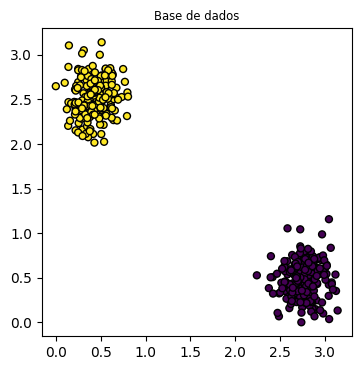

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


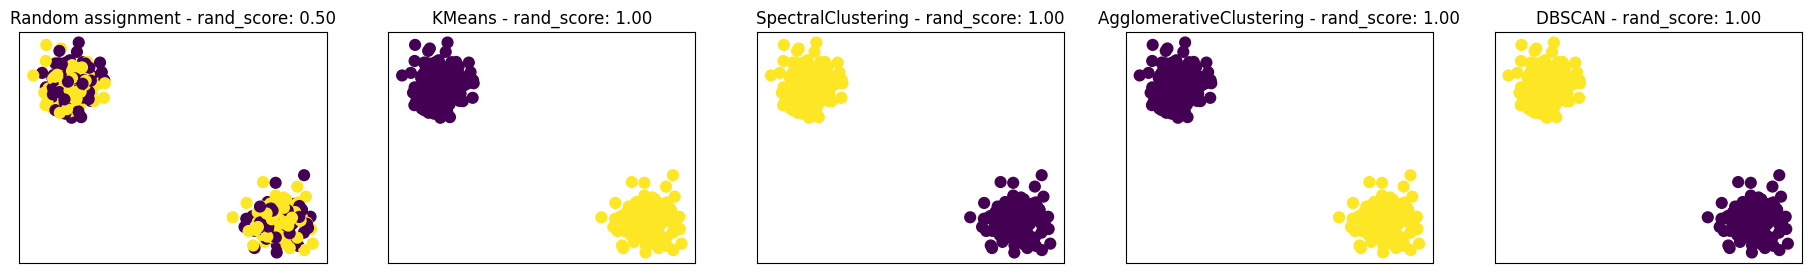

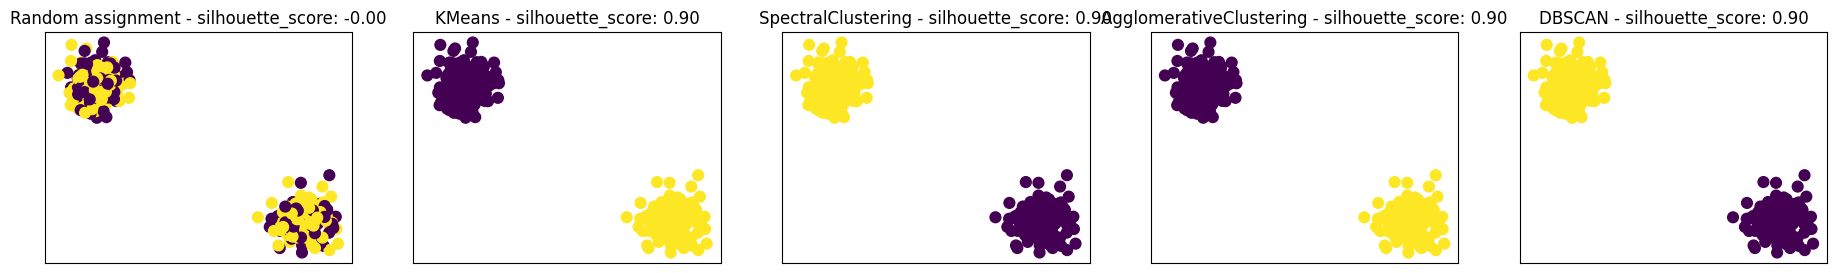

In [8]:
X, y = make_blobs(n_samples=400, centers=2, random_state=29)

X,y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)

cluster_classical(X,y,cluster_metric=rand_score, unsupervised=False)
cluster_classical(X,y,cluster_metric=silhouette_score, unsupervised=True)


### Treinando

In [9]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=1)

0: ──RX(M0)──Rot(5.10,-1.92,-1.66)─╭●──Rot(5.48,-2.39,1.00)──╭●─┤  <Z>
1: ──RX(M1)──Rot(-3.37,2.72,-7.23)─╰X──Rot(-0.78,4.59,-6.47)─╰X─┤     

M0 = 
[3.11736846 0.53526155]
M1 = 
[0.60525063 2.40629115]
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1035156 | Acc validation (metric_square_loss_rand_score): 0.0000000 


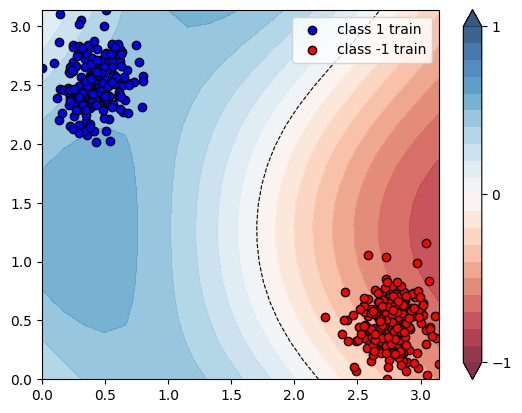

In [10]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [11]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

0: ──RX(M0)──Rot(5.10,-1.92,-1.66)─╭●──Rot(5.48,-2.39,1.00)──╭●─┤  <Z>
1: ──RX(M1)──Rot(-3.37,2.72,-7.23)─╰X──Rot(-0.78,4.59,-6.47)─╰X─┤     

M0 = 
[3.11736846 0.53526155]
M1 = 
[0.60525063 2.40629115]
Iter:     1 | Cost (metric_square_loss_silhouette): 1.0000000 | Acc validation (metric_square_loss_rand_score): 0.0149231 


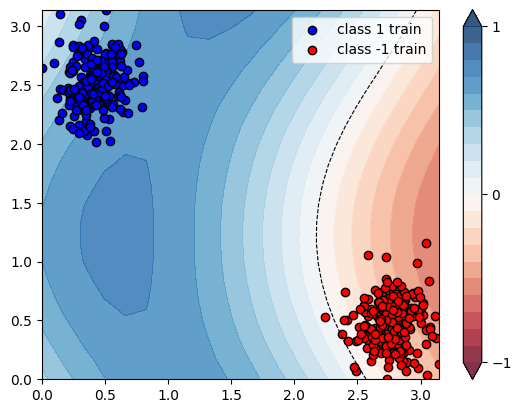

In [12]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [13]:
circuit = circuit_type2
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=4,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=1)

0: ──RX(M0)──Rot(5.10,-1.92,-1.66)─╭●──Rot(5.48,-2.39,1.00)──╭X──Rot(-1.01,-1.21,3.56)──╭●
1: ──RX(M1)──Rot(-3.37,2.72,-7.23)─╰X──Rot(-0.78,4.59,-6.47)─╰●──Rot(-3.46,-0.54,-2.76)─╰X

───Rot(0.13,1.83,-3.46)─╭X─┤  <Z>
───Rot(3.60,2.83,1.58)──╰●─┤     

M0 = 
[3.11736846 0.53526155]
M1 = 
[0.60525063 2.40629115]
Iter:     1 | Cost (metric_square_loss_silhouette): 0.2495117 | Acc validation (metric_square_loss_rand_score): 0.1130981 


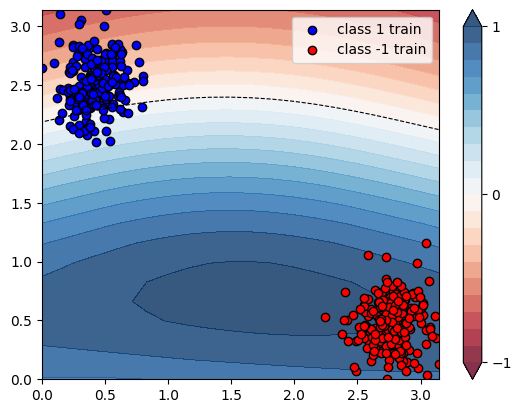

In [14]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [15]:
circuit = circuit_type2
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=4,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

0: ──RX(M0)──Rot(5.10,-1.92,-1.66)─╭●──Rot(5.48,-2.39,1.00)──╭X──Rot(-1.01,-1.21,3.56)──╭●
1: ──RX(M1)──Rot(-3.37,2.72,-7.23)─╰X──Rot(-0.78,4.59,-6.47)─╰●──Rot(-3.46,-0.54,-2.76)─╰X

───Rot(0.13,1.83,-3.46)─╭X─┤  <Z>
───Rot(3.60,2.83,1.58)──╰●─┤     

M0 = 
[3.11736846 0.53526155]
M1 = 
[0.60525063 2.40629115]
Iter:     1 | Cost (metric_square_loss_silhouette): 0.5703125 | Acc validation (metric_square_loss_rand_score): 0.1304932 


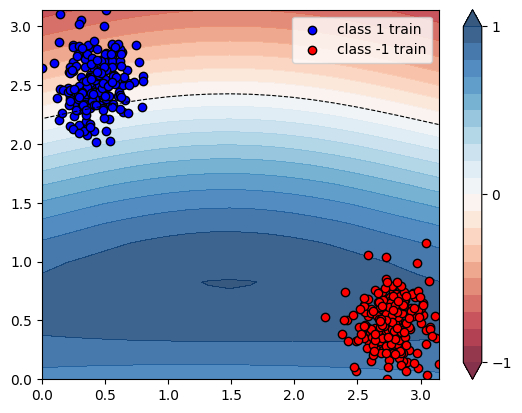

In [16]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [17]:
circuit = circuit_type3
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

0: ──RX(M0)──Rot(5.10,-1.92,-1.66)─╭●──Rot(5.48,-2.39,1.00)──╭●──Rot(-1.01,-1.21,3.56)──╭●
1: ──RX(M1)──Rot(-3.37,2.72,-7.23)─╰X──Rot(-0.78,4.59,-6.47)─╰X──Rot(-3.46,-0.54,-2.76)─╰X

───Rot(0.13,1.83,-3.46)─╭●──Rot(2.83,-2.15,-0.39)─╭●──Rot(-2.17,-1.25,-2.16)─╭●─┤  <Z>
───Rot(3.60,2.83,1.58)──╰X──Rot(-2.94,-0.84,1.67)─╰X──Rot(-2.66,-2.11,-0.04)─╰X─┤     

M0 = 
[3.11736846 0.53526155]
M1 = 
[0.60525063 2.40629115]
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1240234 | Acc validation (metric_square_loss_rand_score): 0.0630493 


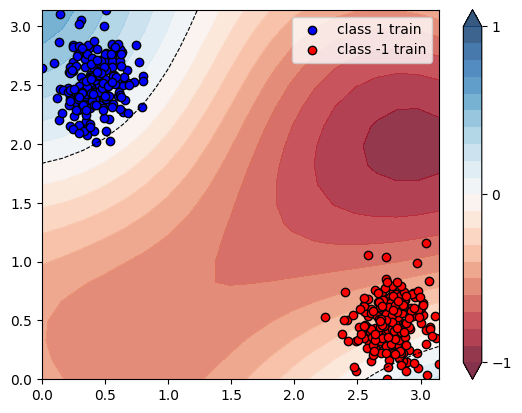

In [18]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi,weights=weights, bias=bias)

In [19]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

0: ──RX(M0)──Rot(5.10,-1.92,-1.66)─╭●──Rot(5.48,-2.39,1.00)──╭X──Rot(-1.01,-1.21,3.56)──╭●
1: ──RX(M1)──Rot(-3.37,2.72,-7.23)─╰X──Rot(-0.78,4.59,-6.47)─╰●──Rot(-3.46,-0.54,-2.76)─╰X

───Rot(0.13,1.83,-3.46)─╭●──Rot(2.83,-2.15,-0.39)─╭X──Rot(-2.17,-1.25,-2.16)─╭●─┤  <Z>
───Rot(3.60,2.83,1.58)──╰X──Rot(-2.94,-0.84,1.67)─╰●──Rot(-2.66,-2.11,-0.04)─╰X─┤     

M0 = 
[3.11736846 0.53526155]
M1 = 
[0.60525063 2.40629115]
Iter:     1 | Cost (metric_square_loss_silhouette): 1.0527344 | Acc validation (metric_square_loss_rand_score): 0.0000000 


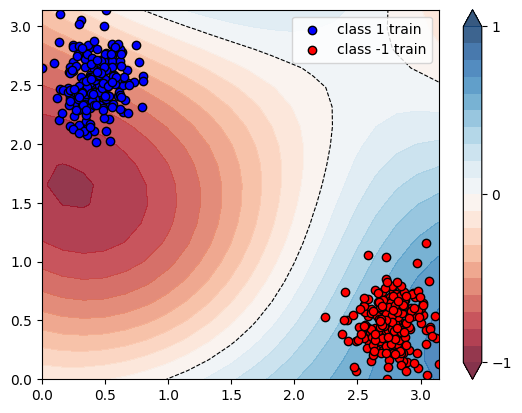

In [20]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi,weights=weights, bias=bias)

## Base de dados - 4 bolhas / 2 classes

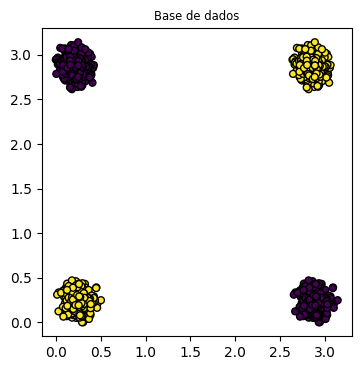

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


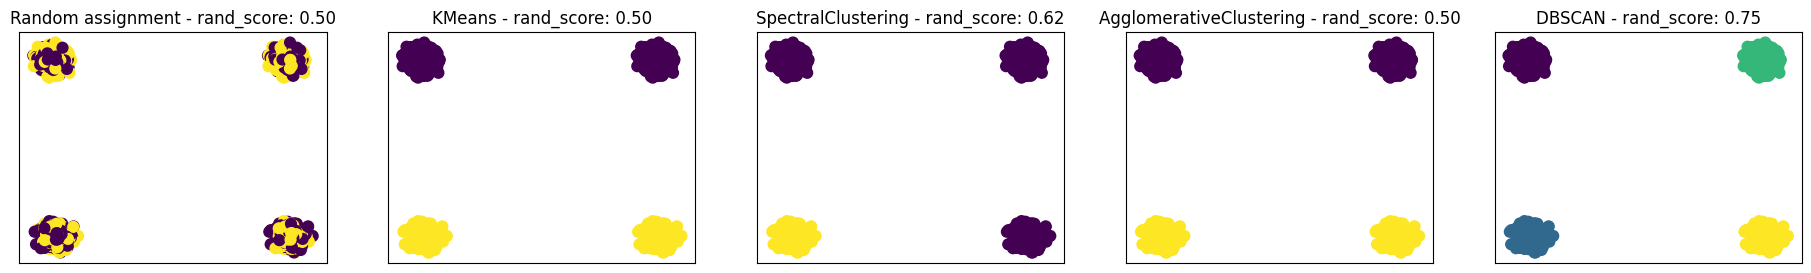

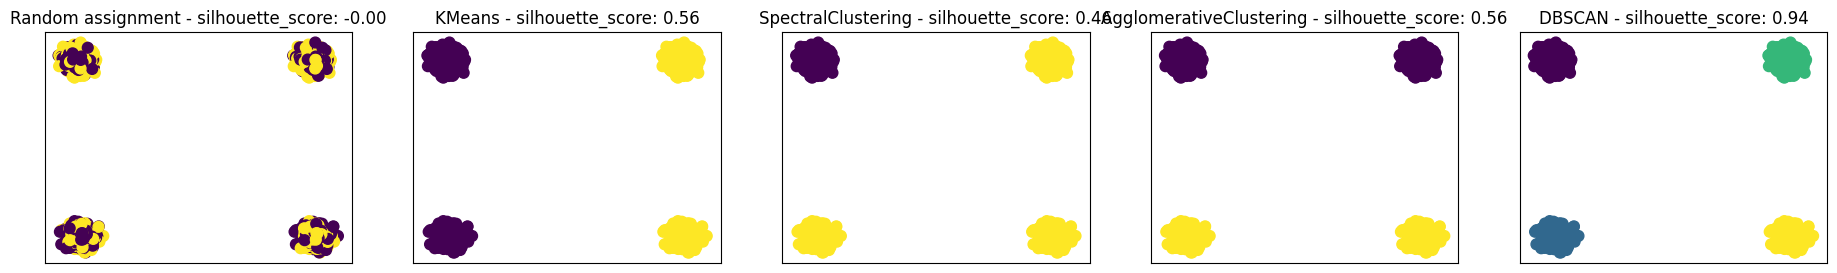

In [21]:
num_classes = 2
feature_size = 2
X1, y1 = make_blobs(random_state=0,n_features=feature_size, centers=num_classes,n_samples=1000, cluster_std=0.15)
X2 = X1.copy()
a1 = np.where(X2[:,0] >1.5, X2[:,0]-1, X2[:,0])
a2 = np.where(X2[:,1] >3, X2[:,1]+1, X2[:,1])
X2 = np.array(np.concatenate((np.matrix(a1).T,np.matrix(a2).T),axis=1))
X1 = X2.copy()
X1[:,0] = X1[:,0]+5
y2 = (y1.copy()+1)%2
X3 = np.concatenate((X2,X1),axis=0)
y3 = np.concatenate((y1,y2),axis=0)

X = X3
y = y3

X,y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)

cluster_classical(X,y,cluster_metric=rand_score, unsupervised=False)
cluster_classical(X,y,cluster_metric=silhouette_score, unsupervised=True)


In [22]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

0: ──RX(M0)──Rot(5.10,-1.92,-1.66)─╭●──Rot(5.48,-2.39,1.00)──╭●─┤  <Z>
1: ──RX(M1)──Rot(-3.37,2.72,-7.23)─╰X──Rot(-0.78,4.59,-6.47)─╰X─┤     

M0 = 
[0.17014095 2.8519    ]
M1 = 
[0.35830425 2.80304722]
Iter:     1 | Cost (metric_square_loss_rand_score): 0.4804688 | Acc validation (metric_square_loss_rand_score): 0.4804688 
Iter:     2 | Cost (metric_square_loss_rand_score): 0.4606934 | Acc validation (metric_square_loss_rand_score): 0.4606934 
Iter:     3 | Cost (metric_square_loss_rand_score): 0.4606934 | Acc validation (metric_square_loss_rand_score): 0.4606934 
Iter:     4 | Cost (metric_square_loss_rand_score): 0.4606934 | Acc validation (metric_square_loss_rand_score): 0.4606934 
Iter:     5 | Cost (metric_square_loss_rand_score): 0.4604492 | Acc validation (metric_square_loss_rand_score): 0.4604492 
Iter:     6 | Cost (metric_square_loss_rand_score): 0.4604492 | Acc validation (metric_square_loss_rand_score): 0.4604492 
Iter:     7 | Cost (metric_square_loss_rand_score): 0.44970

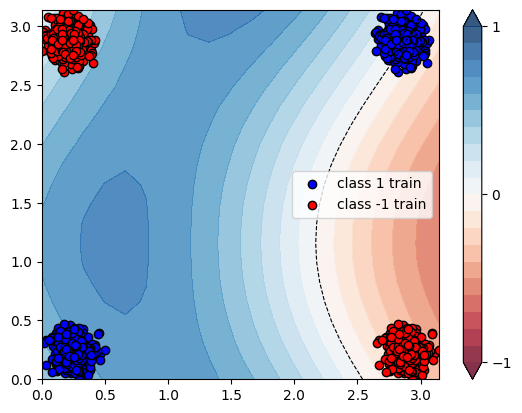

In [23]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [24]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

0: ──RX(M0)──Rot(5.10,-1.92,-1.66)─╭●──Rot(5.48,-2.39,1.00)──╭●──Rot(-1.01,-1.21,3.56)──╭●
1: ──RX(M1)──Rot(-3.37,2.72,-7.23)─╰X──Rot(-0.78,4.59,-6.47)─╰X──Rot(-3.46,-0.54,-2.76)─╰X

───Rot(0.13,1.83,-3.46)─╭●──Rot(2.83,-2.15,-0.39)─╭●──Rot(-2.17,-1.25,-2.16)─╭●─┤  <Z>
───Rot(3.60,2.83,1.58)──╰X──Rot(-2.94,-0.84,1.67)─╰X──Rot(-2.66,-2.11,-0.04)─╰X─┤     

M0 = 
[0.17014095 2.8519    ]
M1 = 
[0.35830425 2.80304722]
Iter:     1 | Cost (metric_square_loss_rand_score): 0.2089844 | Acc validation (metric_square_loss_rand_score): 0.2089844 
Iter:     2 | Cost (metric_square_loss_rand_score): 0.2329102 | Acc validation (metric_square_loss_rand_score): 0.2329102 
Iter:     3 | Cost (metric_square_loss_rand_score): 0.0591736 | Acc validation (metric_square_loss_rand_score): 0.0591736 
Iter:     4 | Cost (metric_square_loss_rand_score): 0.0129242 | Acc validation (metric_square_loss_rand_score): 0.0129242 
Iter:     5 | Cost (metric_square_loss_rand_score): 0.0129242 | Acc validation (metric_squ

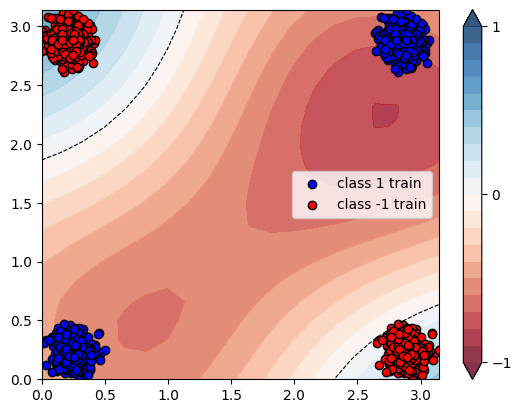

In [25]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [26]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

0: ──RX(M0)──Rot(5.10,-1.92,-1.66)─╭●──Rot(5.48,-2.39,1.00)──╭X──Rot(-1.01,-1.21,3.56)──╭●
1: ──RX(M1)──Rot(-3.37,2.72,-7.23)─╰X──Rot(-0.78,4.59,-6.47)─╰●──Rot(-3.46,-0.54,-2.76)─╰X

───Rot(0.13,1.83,-3.46)─╭●──Rot(2.83,-2.15,-0.39)─╭X──Rot(-2.17,-1.25,-2.16)─╭●─┤  <Z>
───Rot(3.60,2.83,1.58)──╰X──Rot(-2.94,-0.84,1.67)─╰●──Rot(-2.66,-2.11,-0.04)─╰X─┤     

M0 = 
[0.17014095 2.8519    ]
M1 = 
[0.35830425 2.80304722]
Iter:     1 | Cost (metric_square_loss_rand_score): 0.3771973 | Acc validation (metric_square_loss_rand_score): 0.3771973 


KeyboardInterrupt: 

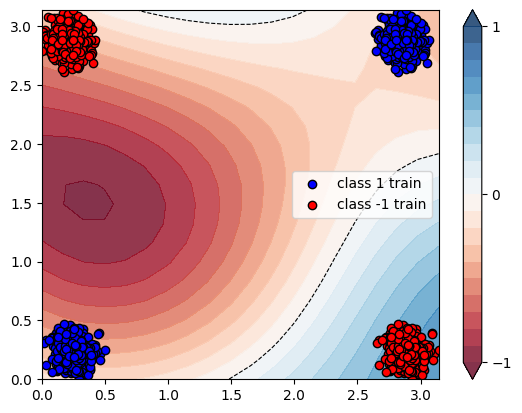

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

Iter:     1 | Cost (metric_square_loss_rand_score): 0.0000000 | Acc validation (metric_square_loss_rand_score): 0.0000000 
Iter:     2 | Cost (metric_square_loss_rand_score): 0.0000000 | Acc validation (metric_square_loss_rand_score): 0.0000000 
Iter:     3 | Cost (metric_square_loss_rand_score): 0.0000000 | Acc validation (metric_square_loss_rand_score): 0.0000000 
Iter:     4 | Cost (metric_square_loss_rand_score): 0.0000000 | Acc validation (metric_square_loss_rand_score): 0.0000000 
Iter:     5 | Cost (metric_square_loss_rand_score): 0.0000000 | Acc validation (metric_square_loss_rand_score): 0.0000000 
Iter:     6 | Cost (metric_square_loss_rand_score): 0.0000000 | Acc validation (metric_square_loss_rand_score): 0.0000000 
Iter:     7 | Cost (metric_square_loss_rand_score): 0.0000000 | Acc validation (metric_square_loss_rand_score): 0.0000000 
Iter:     8 | Cost (metric_square_loss_rand_score): 0.0000000 | Acc validation (metric_square_loss_rand_score): 0.0000000 
Iter:     9 | Co

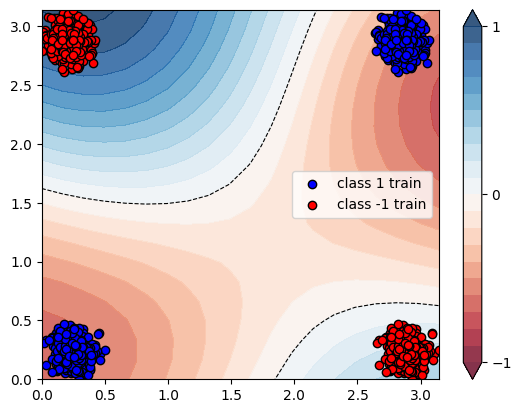

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type2
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

Iter:     1 | Cost (metric_square_loss_rand_score): 0.3776855 | Acc validation (metric_square_loss_rand_score): 0.3776855 
Iter:     2 | Cost (metric_square_loss_rand_score): 0.3752441 | Acc validation (metric_square_loss_rand_score): 0.3752441 
Iter:     3 | Cost (metric_square_loss_rand_score): 0.3752441 | Acc validation (metric_square_loss_rand_score): 0.3752441 
Iter:     4 | Cost (metric_square_loss_rand_score): 0.3752441 | Acc validation (metric_square_loss_rand_score): 0.3752441 
Iter:     5 | Cost (metric_square_loss_rand_score): 0.3752441 | Acc validation (metric_square_loss_rand_score): 0.3752441 
Iter:     6 | Cost (metric_square_loss_rand_score): 0.3752441 | Acc validation (metric_square_loss_rand_score): 0.3752441 
Iter:     7 | Cost (metric_square_loss_rand_score): 0.3581543 | Acc validation (metric_square_loss_rand_score): 0.3581543 
Iter:     8 | Cost (metric_square_loss_rand_score): 0.3586426 | Acc validation (metric_square_loss_rand_score): 0.3586426 
Iter:     9 | Co

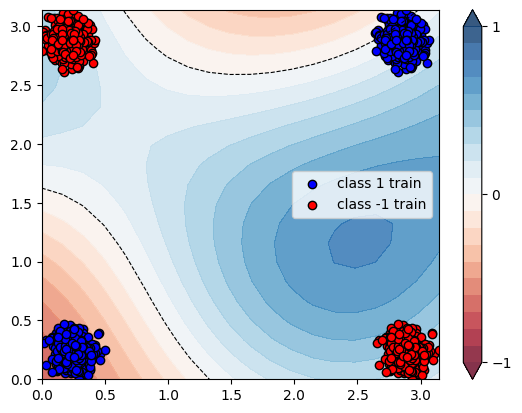

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type3
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

Iter:     1 | Cost (metric_square_loss_rand_score): 0.4941406 | Acc validation (metric_square_loss_rand_score): 0.4941406 
Iter:     2 | Cost (metric_square_loss_rand_score): 0.4145508 | Acc validation (metric_square_loss_rand_score): 0.4145508 
Iter:     3 | Cost (metric_square_loss_rand_score): 0.4541016 | Acc validation (metric_square_loss_rand_score): 0.4541016 
Iter:     4 | Cost (metric_square_loss_rand_score): 0.4562988 | Acc validation (metric_square_loss_rand_score): 0.4562988 
Iter:     5 | Cost (metric_square_loss_rand_score): 0.4052734 | Acc validation (metric_square_loss_rand_score): 0.4052734 
Iter:     6 | Cost (metric_square_loss_rand_score): 0.3879395 | Acc validation (metric_square_loss_rand_score): 0.3879395 
Iter:     7 | Cost (metric_square_loss_rand_score): 0.3879395 | Acc validation (metric_square_loss_rand_score): 0.3879395 
Iter:     8 | Cost (metric_square_loss_rand_score): 0.3906250 | Acc validation (metric_square_loss_rand_score): 0.3906250 
Iter:     9 | Co

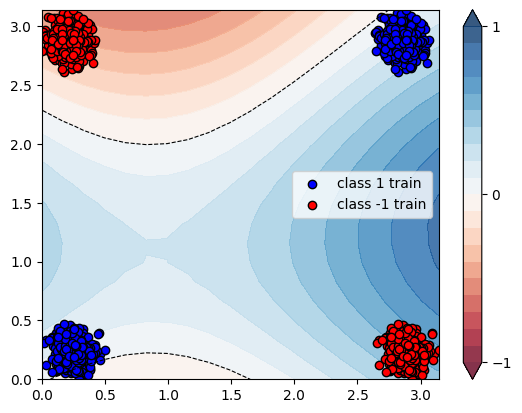

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=50)

Iter:     1 | Cost (metric_square_loss_rand_score): 0.3757324 | Acc validation (metric_square_loss_rand_score): 0.5004883 
Iter:     2 | Cost (metric_square_loss_rand_score): 0.3757324 | Acc validation (metric_square_loss_rand_score): 0.5004883 
Iter:     3 | Cost (metric_square_loss_rand_score): 0.3752441 | Acc validation (metric_square_loss_rand_score): 0.5000000 
Iter:     4 | Cost (metric_square_loss_rand_score): 0.3752441 | Acc validation (metric_square_loss_rand_score): 0.5004883 
Iter:     5 | Cost (metric_square_loss_rand_score): 0.3752441 | Acc validation (metric_square_loss_rand_score): 0.5004883 
Iter:     6 | Cost (metric_square_loss_rand_score): 0.3742676 | Acc validation (metric_square_loss_rand_score): 0.5004883 
Iter:     7 | Cost (metric_square_loss_rand_score): 0.3732910 | Acc validation (metric_square_loss_rand_score): 0.5004883 
Iter:     8 | Cost (metric_square_loss_rand_score): 0.3537598 | Acc validation (metric_square_loss_rand_score): 0.5000000 
Iter:     9 | Co

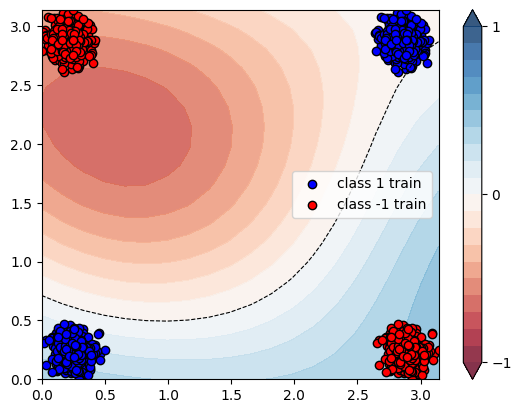

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)